In [1]:
import pandas as pd
import glob

def prepare_water_quality_data(path_pattern, water_type):
    files = glob.glob(path_pattern)  # Match all files (e.g., "data/rivers_*.csv")
    all_data = []

    for file in files:
        year = int(file.split('_')[-1].split('.')[0])
        df = pd.read_csv(file)
        df['YEAR'] = year

        # Clean common columns
        df['STATE'] = df['STATE'].str.upper().str.strip()

        # Rename PH_Max to pH_Max if needed
        df = df.rename(columns=lambda col: col.replace('PH_', 'pH_'))

        numeric_columns = ['pH_Min', 'pH_Max', 'DO_Min', 'DO_MAX', 'BOD_Min', 'BOD_Max', 
                           'TOTALCOLIFORM_Min', 'TOTALCOLIFORM_Max', 'FLUORIDE_Min', 'FLUORIDE_Max']
        for col in numeric_columns:
            if col in df:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)  # Convert to numeric and replace NaN with 0

        # Compute averages for available parameters
        if 'pH_Min' in df :
            df['pH_Min_Avg'] = df['pH_Min'] 
        if 'pH_Max' in df:
            df['pH_Max_Avg'] = df['pH_Max']
        
        if 'DO_Min' in df.columns and 'DO_MAX' in df.columns:
            df['DO_Avg'] = (df['DO_Min'] + df['DO_MAX']) / 2
        else:
            # print(f"Skipping DO_Avg computation for file: {file} as required columns are missing.")
            df['DO_Avg'] = None
        if 'BOD_Min' in df and 'BOD_Max' in df:
            df['BOD_Avg'] = (df['BOD_Min'] + df['BOD_Max']) / 2
        if 'TOTALCOLIFORM_Min' in df and 'TOTALCOLIFORM_Max' in df:
            df['Coliform_Avg'] = (df['TOTALCOLIFORM_Min'] + df['TOTALCOLIFORM_Max']) / 2
        if water_type == 'groundwater' and 'FLUORIDE_Min' in df and 'FLUORIDE_Max' in df:
            df['Fluoride_Avg'] = (df['FLUORIDE_Min'] + df['FLUORIDE_Max']) / 2

        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)

    # Group by STATE and YEAR
    group_columns = ['STATE', 'YEAR']
    avg_columns = ['pH_Min_Avg', 'pH_Max_Avg','DO_Avg', 'BOD_Avg', 'Coliform_Avg']
    if water_type == 'groundwater':
        avg_columns.append('Fluoride_Avg')

    result_df = combined_df.groupby(group_columns)[avg_columns].mean().reset_index()

    return result_df


In [2]:
# For rivers
river_df = prepare_water_quality_data("./data/rivers_with_locations/rivers_with_location_*.csv", "rivers")

# For seas
# first remove water bodies of types drains and industrial drains
drains = ["DRAIN", "INDUSTRIAL DRAIN"]


seas_files = glob.glob("./data/seas_with_locations/seas_with_location_*.csv")
for file in seas_files:
    seas_df = pd.read_csv(file)
    seas_df = seas_df[~seas_df['WATER_BODY_TYPE'].str.strip().str.upper().isin(drains)]
    seas_df.to_csv(file, index=False)
seas_df = prepare_water_quality_data("./data/seas_with_locations/seas_with_location_*.csv", "seas")

# For groundwater
groundwater_df = prepare_water_quality_data("./data/groundwater_with_locations/ground_with_location_*.csv", "groundwater")


C:\Users\Bhanu\AppData\Local\Temp\ipykernel_25196\1882135722.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_data, ignore_index=True)


In [3]:
# #print all distinct values of states
# print("Distinct States in Rivers Data:")
# print(river_df['STATE'].unique())
# print(len(river_df['STATE'].unique()))



In [ ]:
import pandas as pd
from rapidfuzz import process, fuzz

# Your raw state column
state_column = river_df['STATE']  # Or seas_df['STATE'] etc.

# Reference list of correct state names
valid_states = [
    'ANDHRA PRADESH', 'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHHATTISGARH',
    'DELHI', 'GOA', 'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU & KASHMIR',
    'JHARKHAND', 'KARNATAKA', 'KERALA', 'MADHYA PRADESH', 'MAHARASHTRA',
    'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND', 'ODISHA', 'PUDUCHERRY',
    'PUNJAB', 'RAJASTHAN', 'SIKKIM', 'TAMIL NADU', 'TELANGANA', 'TRIPURA',
    'UTTAR PRADESH', 'UTTARAKHAND', 'WEST BENGAL'
]

def clean_state_name(state):
    if pd.isnull(state) or state.strip() == '-':
        return None
    state = state.replace('\n', ' ').replace('_', ' ').replace('-', ' ').upper().strip()
    best_match = process.extractOne(state, valid_states, scorer=fuzz.ratio)
    if best_match and best_match[1] >= 80:  # threshold: how strict to match
        return best_match[0]
    else:
        return state  # keep it as-is if no good match

# Apply to your dataframe
def clean_and_replace_states(df):
	# Clean state names
	df['STATE'] = df['STATE'].apply(clean_state_name)
	# Replace specific state names
	df['STATE'] = df['STATE'].replace({'PUDUCHERRY': 'PONDICHERRY', 'ORISSA': 'ODISHA'})
	return df

# Apply the function to each dataframe
river_df = clean_and_replace_states(river_df)
seas_df = clean_and_replace_states(seas_df)
groundwater_df = clean_and_replace_states(groundwater_df)

# # Print unique states for verification
# print("Distinct States in Rivers Data:")
# print(river_df['STATE'].unique())

# print("Distinct States in Seas Data:")
# print(seas_df['STATE'].unique())

# print("Distinct States in Groundwater Data:")
# print(groundwater_df['STATE'].unique())
# Combine similar state names under a unified name for groundwater data
groundwater_df['STATE'] = groundwater_df['STATE'].replace({
	'DADRA & NAGAR HAVELI': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DADRA NAGAR HAVELI': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DAMAN': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DAMAN & DIU': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DAMAN & DIU, DADRA & NAGAR HAVELI': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DAMAN AND DIU': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DAMAN AND DIU, DADRA AND NAGAR HAVELI': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI',
	'DAMAN, DIU, DADRA NAGAR HAVELI': 'DAMAN AND DIU, DADRA AND NAGAR HAVELI'
})

# Print unique states for verification
# print("Distinct States in Groundwater Data after combining similar names:")
# print(groundwater_df['STATE'].unique())
# Combine similar state names under a unified name for river, seas, and groundwater data
state_combinations = {
	'HARYANA/CPCB': 'HARYANA',
	'PUNJAB/CPCB': 'PUNJAB'
}

river_df['STATE'] = river_df['STATE'].replace(state_combinations)
seas_df['STATE'] = seas_df['STATE'].replace(state_combinations)
groundwater_df['STATE'] = groundwater_df['STATE'].replace(state_combinations)
# convert seas_df to csv
# seas_df.to_csv("./data/seas_with_locations/seas_with_location_combined.csv", index=False)
# # convert groundwater_df to csv
# groundwater_df.to_csv("./data/groundwater_with_locations/ground_with_location_combined.csv", index=False)

# Print unique states for verification
# print("Distinct States in Rivers Data after combining similar names:")
# # print(river_df['STATE'].unique())

# print("Distinct States in Seas Data after combining similar names:")
# # print(seas_df['STATE'].unique())

# print("Distinct States in Groundwater Data after combining similar names:")
# print(groundwater_df['STATE'].unique())

In [5]:
# raw_states = state_column.unique()
# state_mapping = {s: clean_state_name(s) for s in raw_states}
# print(pd.DataFrame(state_mapping.items(), columns=["Original", "Cleaned"]))
# duplicates = river_df[river_df.duplicated(subset=['STATE', 'YEAR'], keep=False)]
# print(duplicates)

In [6]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assume river_df, groundwater_df, and seas_df are already loaded properly
data_sources = {
    'Rivers': river_df,
    'Groundwater': groundwater_df,
    'Seas': seas_df
}

parameter_options = {
    'pH_Min': 'pH_Min_Avg',
    'pH_Max': 'pH_Max_Avg',
    'DO (Dissolved Oxygen)': 'DO_Avg',
    'BOD (Biochemical Oxygen Demand)': 'BOD_Avg',
    'Coliform': 'Coliform_Avg',
    'Fluoride': 'Fluoride_Avg'  # Only in Groundwater
}

# Get all unique states across all datasets
all_states = sorted(
    state for state in (
        set(river_df['STATE'].unique())
        | set(groundwater_df['STATE'].unique())
        | set(seas_df['STATE'].unique())
    ) if state is not None
)

app = dash.Dash(__name__)
app.title = "Water Quality Dashboard"

app.layout = html.Div([
    html.H1("🌊 Water Quality Analysis Dashboard", style={"textAlign": "center", "color": "#333"}),

    # ------------------- Heatmap Section -------------------
    html.Div([
        html.Label("Select Water Quality Parameter (for Heatmap):", style={"color": "#333"}),
        dcc.Dropdown(
            id='parameter',
            options=[{'label': k, 'value': v} for k, v in parameter_options.items()],
            value='pH_Min_Avg',
            style={"color": "#333"}
        ),

        html.Label("Select Water Body Type:", style={"color": "#333"}),
        dcc.Dropdown(
            id='data-type',
            options=[{'label': k, 'value': k} for k in data_sources.keys()],
            value='Rivers',
            style={"color": "#333"}
        ),
    ], style={'width': '45%', 'margin': '10px'}),

    dcc.Graph(id='heatmap-output'),

    # ------------------- Line Chart Section -------------------
    html.H3("📈 Compare Parameter Trends Across Water Bodies for a Specific State", style={"textAlign": "center", "color": "#333"}),

    html.Div([
        html.Label("Select Parameter:", style={"color": "#333"}),
        dcc.Dropdown(
            id='compare-parameter',
            options=[{'label': k, 'value': v} for k, v in parameter_options.items() if v != 'Fluoride_Avg'],
            value='pH_Min_Avg',
            style={"marginBottom": "15px", "color": "#333"}
        ),

        html.Label("Select State:", style={"color": "#333"}),
        dcc.Dropdown(
            id='state-selector',
            options=[{'label': state.title(), 'value': state} for state in all_states],
            value=all_states[0],
            style={"color": "#333"}
        ),
    ], style={'width': '60%', 'margin': '0 auto'}),

    dcc.Graph(id='comparison-linechart')

], style={"backgroundColor": "#f9f9f9", "padding": "20px"})


# ------------------ Heatmap Callback ------------------
@app.callback(
    Output('heatmap-output', 'figure'),
    Input('data-type', 'value'),
    Input('parameter', 'value')
)
def update_heatmap(data_type, parameter_col):
    df = data_sources[data_type]

    if parameter_col == 'Fluoride_Avg' and 'Fluoride_Avg' not in df.columns:
        return px.imshow([], labels=dict(x="Year", y="State", color="Value"),
                         title="Fluoride not available for this dataset.")

    df[parameter_col] = pd.to_numeric(df[parameter_col], errors='coerce')
    aggregated = df.groupby(['STATE', 'YEAR'])[parameter_col].mean().reset_index()
    pivoted = aggregated.pivot(index='STATE', columns='YEAR', values=parameter_col)

    fig = px.imshow(
        pivoted,
        labels=dict(x="Year", y="State", color=parameter_col.replace("_Avg", "")),
        x=pivoted.columns,
        y=pivoted.index,
        aspect="auto",
        color_continuous_scale='YlGnBu',
        text_auto=".2f"
    )

    fig.update_layout(
        title=f"{parameter_col.replace('_Avg','')} Heatmap for {data_type}",
        paper_bgcolor='#f9f9f9',
        plot_bgcolor='#f9f9f9',
        font_color='#333',
        title_font_size=20,
        height=800
    )

    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='#aaa')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='#aaa')

    return fig


# ------------------ Line Chart Callback ------------------
@app.callback(
    Output('comparison-linechart', 'figure'),
    Input('compare-parameter', 'value'),
    Input('state-selector', 'value')
)
def update_comparison_chart(selected_param, selected_state):
    fig = go.Figure()

    for source, df in data_sources.items():
        if selected_param not in df.columns:
            continue
        state_df = df[df['STATE'] == selected_state]
        if state_df.empty:
            continue
        state_df = state_df.copy()  # Optional but good practice to avoid other side effects
        state_df.loc[:, selected_param] = pd.to_numeric(state_df[selected_param], errors='coerce')

        yearly_avg = state_df.groupby('YEAR')[selected_param].mean().reset_index()

        fig.add_trace(go.Scatter(
            x=yearly_avg['YEAR'],
            y=yearly_avg[selected_param],
            mode='lines+markers',
            name=source
        ))

    fig.update_layout(
        title=f"{selected_param.replace('_Avg', '')} Trends in {selected_state.title()} Across Water Bodies",
        xaxis_title="Year",
        yaxis_title="Average Value",
        template="plotly_white",
        height=600,
        legend_title_text="Water Body Type"
    )

    return fig


if __name__ == '__main__':
    app.run(debug=True)


In [7]:
# import dash
# from dash import dcc, html, Input, Output
# import pandas as pd
# import plotly.express as px

# # Use your preprocessed datasets here:
# # river_df = ...
# # groundwater_df = ...
# # seas_df = ...

# data_sources = {
#     'Rivers': river_df,
#     'Groundwater': groundwater_df,
#     'Seas': seas_df
# }

# parameter_options = {
#     'pH': 'pH_Avg',
#     'DO (Dissolved Oxygen)': 'DO_Avg',
#     'BOD (Biochemical Oxygen Demand)': 'BOD_Avg',
#     'Coliform': 'Coliform_Avg',
#     'Fluoride': 'Fluoride_Avg'  # Only in Groundwater
# }

# app = dash.Dash(__name__)
# app.title = "Water Quality Heatmaps"

# app.layout = html.Div([
#     html.H1("🌊 Water Quality Analysis Dashboard", style={"textAlign": "center", "color": "#333"}),

#     html.Div([
#         html.Label("Select Water Body Type:", style={"color": "#333"}),
#         dcc.Dropdown(
#             id='data-type',
#             options=[{'label': k, 'value': k} for k in data_sources.keys()],
#             value='Rivers',
#             style={"color": "#333"}
#         )
#     ], style={'width': '40%', 'margin': '10px'}),

#     html.Div([
#         html.Label("Select Water Quality Parameter:", style={"color": "#333"}),
#         dcc.Dropdown(
#             id='parameter',
#             options=[{'label': k, 'value': v} for k, v in parameter_options.items()],
#             value='pH_Avg',
#             style={"color": "#333"}
#         )
#     ], style={'width': '40%', 'margin': '10px'}),

#     dcc.Graph(id='heatmap-output')
# ],
# style={"backgroundColor": "#f9f9f9", "padding": "20px"}  # 💡 Light background
# )

# @app.callback(
#     Output('heatmap-output', 'figure'),
#     Input('data-type', 'value'),
#     Input('parameter', 'value')
# )
# def update_heatmap(data_type, parameter_col):
#     df = data_sources[data_type]

#     if parameter_col == 'Fluoride_Avg' and 'Fluoride_Avg' not in df.columns:
#         return px.imshow([], labels=dict(x="Year", y="State", color="Value"), title="Fluoride not available for this dataset.")

#     # Ensure the column is numeric before performing operations
#     df[parameter_col] = pd.to_numeric(df[parameter_col], errors='coerce')
#     aggregated = df.groupby(['STATE', 'YEAR'])[parameter_col].mean().reset_index()
#     pivoted = aggregated.pivot(index='STATE', columns='YEAR', values=parameter_col)

#     fig = px.imshow(
#         pivoted,
#         labels=dict(x="Year", y="State", color=parameter_col.replace("_Avg", "")),
#         x=pivoted.columns,
#         y=pivoted.index,
#         aspect="auto",
#         color_continuous_scale='YlGnBu',  # 🌼 Fresh and light color palette
#         text_auto=".2f"
#     )

#     fig.update_layout(
#         title=f"{parameter_col.replace('_Avg','')} Heatmap for {data_type}",
#         paper_bgcolor='#f9f9f9',
#         plot_bgcolor='#f9f9f9',
#         font_color='#333',
#         title_font_size=20,
#         height=800
#     )

#     fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='#aaa')
#     fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='#aaa')

#     return fig

# if __name__ == '__main__':
#     app.run(debug=True)


['pH_Min_Avg', 'pH_Max_Avg', 'DO_Avg', 'BOD_Avg', 'Coliform_Avg']


C:\Users\Bhanu\AppData\Local\Temp\ipykernel_25196\434000306.py:13: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

C:\Users\Bhanu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



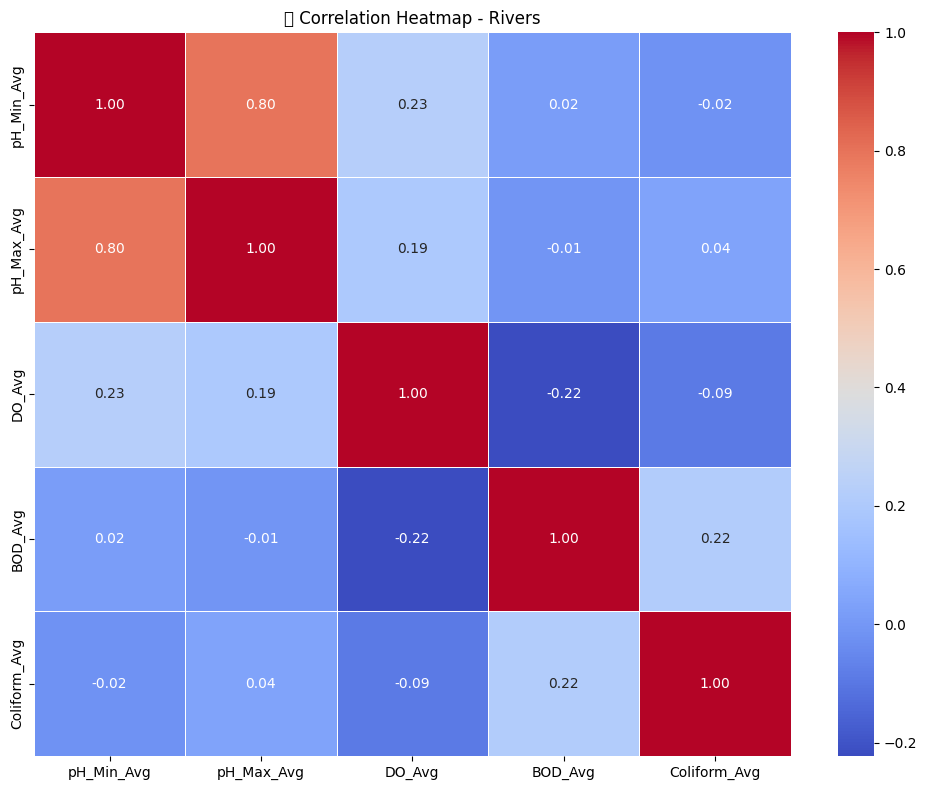

C:\Users\Bhanu\AppData\Local\Temp\ipykernel_25196\434000306.py:13: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

C:\Users\Bhanu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



['pH_Min_Avg', 'pH_Max_Avg', 'DO_Avg', 'BOD_Avg', 'Coliform_Avg']


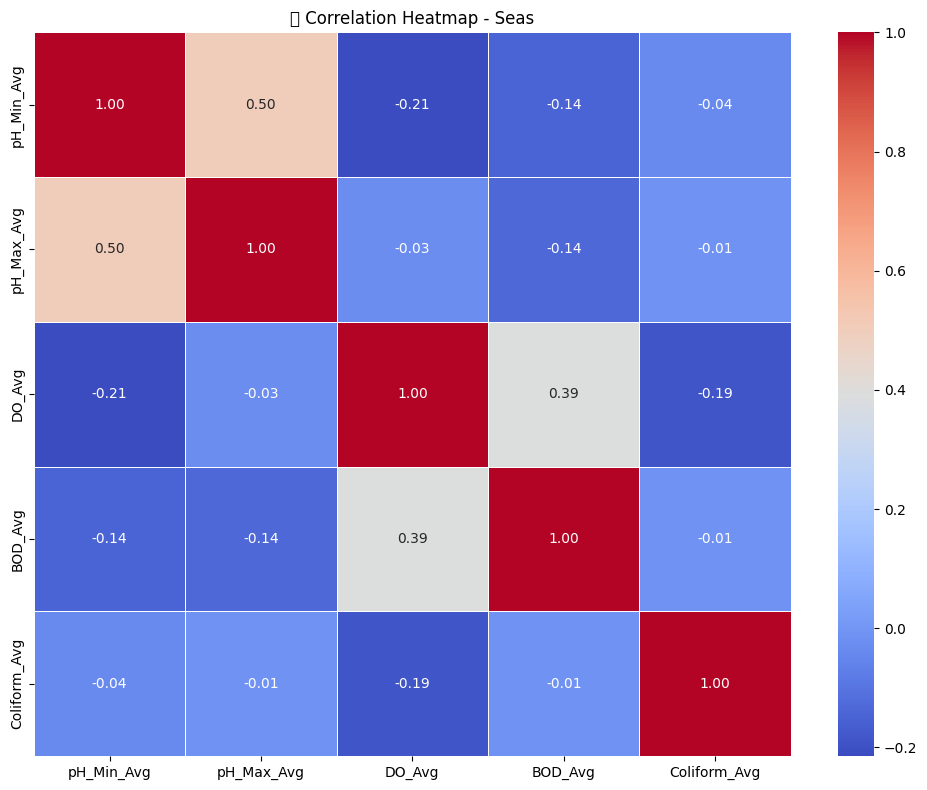

['pH_Min_Avg', 'pH_Max_Avg', 'DO_Avg', 'BOD_Avg', 'Coliform_Avg', 'Fluoride_Avg']


C:\Users\Bhanu\AppData\Local\Temp\ipykernel_25196\434000306.py:13: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.

C:\Users\Bhanu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from current font.



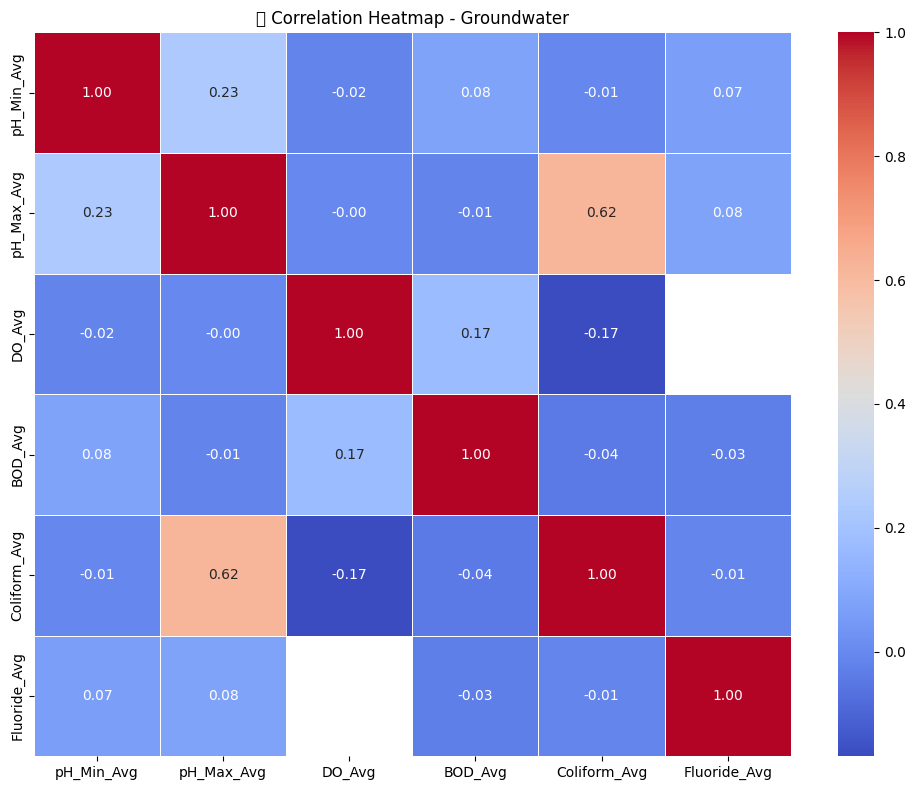

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(df, title):
    # Filter only numeric columns related to water quality
    quality_cols = [col for col in df.columns if '_Avg' in col]
    print (quality_cols)
    corr = df[quality_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'📊 Correlation Heatmap - {title}')
    plt.tight_layout()
    plt.show()

# Example usage
plot_correlation_heatmap(river_df, "Rivers")
plot_correlation_heatmap(seas_df, "Seas")
plot_correlation_heatmap(groundwater_df, "Groundwater")


In [9]:
# import dash
# from dash import dcc, html, Input, Output
# import pandas as pd
# import plotly.graph_objects as go

# # Replace these with your preprocessed dataframes
# data_sources = {
#     'Rivers': river_df,
#     'Groundwater': groundwater_df,
#     'Seas': seas_df
# }

# # Parameter display names and their actual column names
# multi_param_options = {
#     'pH': 'pH_Avg',
#     'DO (Dissolved Oxygen)': 'DO_Avg',
#     'BOD (Biochemical Oxygen Demand)': 'BOD_Avg',
#     'Fecal Coliform': 'Coliform_Avg'
# }

# app = dash.Dash(__name__)
# app.title = "Multi-Parameter Trend Comparison"

# app.layout = html.Div([
#     html.H1("📈 Water Quality Trends by Parameter", style={"textAlign": "center"}),

#     html.Div([
#         html.Label("Select Water Body Type:"),
#         dcc.Dropdown(
#             id='source-dropdown',
#             options=[{'label': k, 'value': k} for k in data_sources.keys()],
#             value='Rivers',
#             style={"marginBottom": "15px"}
#         ),

#         html.Label("Select Parameters to Compare:"),
#         dcc.Dropdown(
#             id='param-dropdown',
#             options=[{'label': k, 'value': v} for k, v in multi_param_options.items()],
#             value=['pH_Avg', 'DO_Avg', 'BOD_Avg'],
#             multi=True
#         )
#     ], style={'width': '50%', 'margin': '0 auto'}),

#     dcc.Graph(id='multi-line-chart')
# ])

# @app.callback(
#     Output('multi-line-chart', 'figure'),
#     Input('source-dropdown', 'value'),
#     Input('param-dropdown', 'value')
# )
# def update_multi_line_chart(data_type, selected_params):
#     df = data_sources[data_type]

#     # Group by year and take average
#     yearly_avg = df.groupby('YEAR')[selected_params].mean().reset_index()

#     # Plot multiple lines
#     fig = go.Figure()
#     for param in selected_params:
#         fig.add_trace(go.Scatter(
#             x=yearly_avg['YEAR'],
#             y=yearly_avg[param],
#             mode='lines+markers',
#             name=param.replace('_Avg', '')
#         ))

#     fig.update_layout(
#         title=f"Trend of Selected Parameters in {data_type}",
#         xaxis_title='Year',
#         yaxis_title='Average Value',
#         height=600,
#         template='plotly_white'
#     )
#     return fig

# if __name__ == '__main__':
#     app.run(debug=True)
